# Import lib

In [1]:
import pythonradex

# # import necessary modules
from pythonradex import radiative_transfer, helpers, LAMDA_file, atomic_transition
from scipy import constants
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from tqdm import tqdm
from scipy import constants

from scipy.stats import norm

# Initial setup

In [2]:
# ============================
# (1) Set up the "true" simulation
# ============================

# Path to the molecular data file (CH3OH from the LAMDA database)
datafilepath_methanol = r"C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\group project\codes\e_ch3oh.dat"

data_methanol = LAMDA_file.read(datafilepath_methanol, read_frequencies=False)

# Geometry and line profile
geometry = "uniform sphere"
line_profile_type = "Gaussian"

# True simulation parameters (using your constants)
N = 1e16 / constants.centi**2  # CH3OH_e column density in m^-2
width_v = 4 * constants.kilo  # line width in m/s (1 km/s * 2)
Tkin = 120  # kinetic temperature in K
LTE_collider_densities_h2only = {"H2": 1e8 / constants.centi**3}  # collider density in m^-3
T_dust = 0
tau_dust = 0
ext_background = helpers.generate_CMB_background(z=0)

# Create the "true" cloud object using your variable names
cloud_metahnol = radiative_transfer.Cloud(
    datafilepath=datafilepath_methanol,
    geometry=geometry,
    line_profile_type=line_profile_type,
    width_v=width_v,
)
cloud_metahnol.update_parameters(
    N=N,
    Tkin=Tkin,
    collider_densities=LTE_collider_densities_h2only,
    ext_background=ext_background,
    T_dust=T_dust,
    tau_dust=tau_dust,
)
cloud_metahnol.solve_radiative_transfer()


# Define a helper function to extract values from the cloud and data file
def extract_values(cloud_name, data_of_molecule):
    # Excitation temperature and optical depth
    Tex = cloud_name.Tex
    tau = cloud_name.tau_nu0_individual_transitions
    # Einstein coefficients and transition frequencies
    Aul = cloud_name.emitting_molecule.A21
    Bul = cloud_name.emitting_molecule.B21
    nu0_array = cloud_name.emitting_molecule.nu0
    # Extract level energies (convert from Joule to Kelvin)
    levels = data_of_molecule["levels"]
    Eu = np.array([level.E for level in levels]) / constants.k
    Eu = Eu[1:]  # remove first component (nan)
    g_weigth = np.array([level.g for level in levels])[1:]

    return Tex, tau, Aul, Bul, nu0_array, Eu, g_weigth


TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH = extract_values(cloud_metahnol, data_methanol)

# For simplicity, take only the first 10 transitions
firstN_transitions = 30
TexCH3OH = TexCH3OH[:firstN_transitions]
tauCH3OH = tauCH3OH[:firstN_transitions]
AulCH3OH = AulCH3OH[:firstN_transitions]
BulCH3OH = BulCH3OH[:firstN_transitions]
nu0_arrayCH3OH = nu0_arrayCH3OH[:firstN_transitions]
EuCH3OH = EuCH3OH[:firstN_transitions]
gCH3OH = gCH3OH[:firstN_transitions]

# Compute the fluxes from the cloud
distance_observer = 100 * constants.parsec  # observer distance in m
source_radius = 10 * constants.au  # source radius in m
source_solid_angle = source_radius**2 * np.pi / distance_observer**2

flux_methanol = cloud_metahnol.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)
# Define an arbitrary fwhm in frequency (using the first transition as reference)
fwhm_frequancy = nu0_arrayCH3OH[0] * 0.2

# Choose a specific transition (e.g. transition 2) for the MCMC fit
choose_transition = 2


# Define a Gaussian function (as in your code)
def gaussian(x, amp, cen, fwhm):
    """Gaussian function with amplitude, center, and FWHM as parameters

    Parameters
    ----------
    x : array_like
        The frequency axis
    amp : float
        Amplitude of the Gaussian
    cen : float
        Center of the Gaussian
    fwhm : float
        Full Width at Half Maximum of the Gaussian

    Returns
    -------
    array_like
        The Gaussian function evaluated at the frequency axis x
    """
    sigma = fwhm / (2 * np.sqrt(2 * np.log(2)))
    return amp * np.exp(-((x - cen) ** 2) / (2 * sigma**2))


c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'


79-78: tau_nu0 = -0.159
46-45: tau_nu0 = -0.21
28-27: tau_nu0 = -2.7e-05
78-77: tau_nu0 = -4.19e-05
20-19: tau_nu0 = -3.19e-06
13-12: tau_nu0 = -0.503
18-17: tau_nu0 = -0.647
10-8: tau_nu0 = -0.297
23-22: tau_nu0 = -0.752
30-27: tau_nu0 = -0.819
37-36: tau_nu0 = -0.852
44-43: tau_nu0 = -0.847
54-53: tau_nu0 = -0.814
65-64: tau_nu0 = -0.757
49-48: tau_nu0 = -3.3e-12
79-77: tau_nu0 = -0.678
92-91: tau_nu0 = -0.593
105-104: tau_nu0 = -0.49
121-120: tau_nu0 = -0.391
14-12: tau_nu0 = -0.0234
136-135: tau_nu0 = -0.102
68-66: tau_nu0 = -1.9e-05
9-7: tau_nu0 = -0.433
38-37: tau_nu0 = -7.06e-06
86-85: tau_nu0 = -0.0455
10-7: tau_nu0 = -1.3e-06
92-89: tau_nu0 = -0.142
59-56: tau_nu0 = -0.188
38-36: tau_nu0 = -3.65e-05
13-11: tau_nu0 = -1.5e-08
66-64: tau_nu0 = -3.21e-05
15-14: tau_nu0 = -1.23e-06
58-55: tau_nu0 = -1.29e-11
19-17: tau_nu0 = -0.0181
80-78: tau_nu0 = -3.17e-05
16-14: tau_nu0 = -0.464
75-73: tau_nu0 = -0.0414
105-103: tau_nu0 = -0.12
15-12: tau_nu0 = -3.53e-05
20-17: tau_nu0 = -0.00

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


# Plot spectum

In [3]:
realistic_fwhm = nu0_arrayCH3OH * (width_v / constants.c)

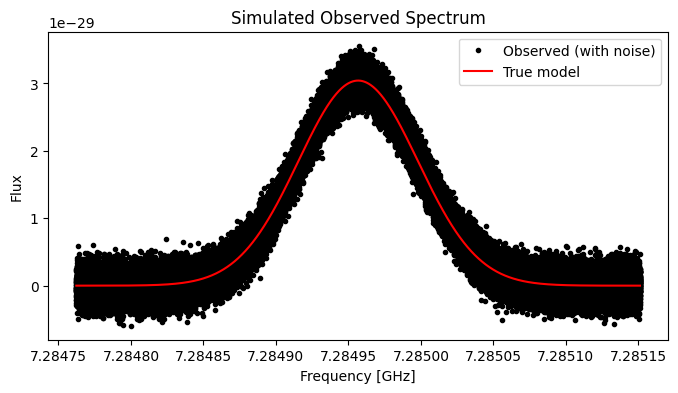

In [4]:
# Create a frequency axis for the line (in Hz)
x = np.linspace(
    nu0_arrayCH3OH[choose_transition] - 2 * realistic_fwhm[choose_transition],
    nu0_arrayCH3OH[choose_transition] + 2 * realistic_fwhm[choose_transition],
    int(1e5),
)
# flux density

# flux_density = cloud_metahnol.spectrum(nu=nu0_arrayCH3OH, solid_angle=source_solid_angle)


# Generate the "true" line profile for the chosen transition
flux_amp_true = flux_methanol[choose_transition]
true_spectrum = gaussian(x, flux_amp_true, nu0_arrayCH3OH[choose_transition], realistic_fwhm[choose_transition])

# Add synthetic noise to mimic observational data (5% noise level)
np.random.seed(42)
noise_std = 0.05 * np.max(true_spectrum)
observed_spectrum = true_spectrum + np.random.normal(0, noise_std, size=x.shape)

# Plot the simulated observed spectrum
plt.figure(figsize=(8, 4))
plt.plot(x / constants.giga, observed_spectrum, "k.", label="Observed (with noise)")
plt.plot(x / constants.giga, true_spectrum, "r-", label="True model")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.title("Simulated Observed Spectrum")
plt.show()

In [5]:
def model_spectrum(x, params):
    """
    Create spectrum, sum of Gaussians.

    Parameters:
        x: array-like, the independent variable (e.g., wavelength)
        params: list or array of parameters. For n Gaussians, params should be of length 3*n,
                where each Gaussian has [amp, cen, fwhm] in order.

    Returns:
        The sum of Gaussians evaluated at x.
    """
    n_gauss = len(params) // 3
    total = np.zeros_like(x)
    for i in range(n_gauss):
        amp = params[3 * i]
        cen = params[3 * i + 1]
        fwhm = params[3 * i + 2]
        total += gaussian(x, amp, cen, fwhm)
    return total

In [6]:
realistic_fwhm

array([ 39200.        ,  45200.        ,  97200.        , 125600.        ,
       132400.        , 162400.        , 198800.00000001, 208400.        ,
       244799.99999999, 266400.        , 297600.00000001, 312000.        ,
       312800.        , 328400.        , 332399.99999999, 332400.        ,
       332800.        , 332400.        , 332800.        , 334000.        ,
       335200.        , 337600.00000001, 340799.99999999, 345200.00000001,
       348000.        , 351200.        , 358400.00000001, 364000.        ,
       366800.        , 376000.        ])

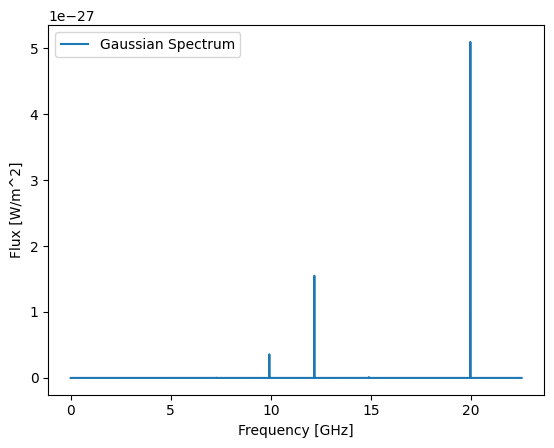

In [7]:
# number of transitions to plot in spectrum
n_trans_spectrum = 10

# generate frequancy space
x = np.linspace(0, nu0_arrayCH3OH[n_trans_spectrum] * 1.01, int(1e5))
params = []
for i in range(n_trans_spectrum):
    params.extend([flux_methanol[i], nu0_arrayCH3OH[i], realistic_fwhm[i]])

# Generate the spectrum
spectrum = model_spectrum(x, params)

# Plot the spectrum
fig, ax = plt.subplots()
plt.plot(x / constants.giga, spectrum, label="Gaussian Spectrum")
plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.show()

# Define the MCMC model functions

In [8]:
# # Our free parameters are:
# #   theta = [Tkin, width_v, log10(n_H2)]
# # where n_H2 will be reconstructed from 10**(log_n_H2) / constants.centi**3


# def simulate_spectrum_from_params(Tkin_candidate, width_v_candidate, log_n_H2_candidate):
#     """Simulate a spectrum from a single transition for a given set of parameters"""

#     # Convert log-density to linear density (matching your units)
#     n_H2_candidate = 10 ** (log_n_H2_candidate) / constants.centi**3
#     # Create a new cloud with the candidate width_v
#     cloud_candidate = radiative_transfer.Cloud(
#         datafilepath=datafilepath_methanol,
#         geometry=geometry,
#         line_profile_type=line_profile_type,
#         width_v=width_v_candidate,
#     )
#     cloud_candidate.update_parameters(
#         N=N,
#         Tkin=Tkin_candidate,
#         collider_densities={"H2": n_H2_candidate},
#         ext_background=ext_background,
#         T_dust=T_dust,
#         tau_dust=tau_dust,
#     )
#     cloud_candidate.solve_radiative_transfer()
#     # Get the flux for the chosen transition
#     flux_candidate = cloud_candidate.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)
#     # TexCH3OH, tauCH3OH, AulCH3OH, BulCH3OH, nu0_arrayCH3OH, EuCH3OH, gCH3OH = extract_values(cloud_metahnol, data_methanol)

#     params = []
#     for i in range(n_trans_spectrum):
#         params.extend([flux_candidate[i], nu0_arrayCH3OH[i], realistic_fwhm[i]])

#     print("flux of spectrum ", flux_candidate)

#     # Build the model line using the same Gaussian profile (center and fwhm_frequancy fixed)
#     medel_all_spectrum = model_spectrum(x, params)
#     # model_line = gaussian(x, flux_candidate, nu0_arrayCH3OH[choose_transition], fwhm_frequancy)
#     return medel_all_spectrum


In [ ]:
def simulate_spectrum_from_params(Tkin_candidate, width_v_candidate, log_n_H2_candidate):
    """Simulate a spectrum from multiple transitions for a given set of parameters"""

    # Convert log-density to linear density (matching your units)
    n_H2_candidate = 10 ** (log_n_H2_candidate) / constants.centi**3
    # Create a new cloud with the candidate width_v
    cloud_candidate = radiative_transfer.Cloud(
        datafilepath=datafilepath_methanol,
        geometry=geometry,
        line_profile_type=line_profile_type,
        width_v=width_v_candidate,
    )
    cloud_candidate.update_parameters(
        N=N,
        Tkin=Tkin_candidate,
        collider_densities={"H2": n_H2_candidate},
        ext_background=ext_background,
        T_dust=T_dust,
        tau_dust=tau_dust,
    )
    cloud_candidate.solve_radiative_transfer()
    # Get the flux for the chosen transition
    flux_candidate = cloud_candidate.fluxes_of_individual_transitions(transitions=list(range(firstN_transitions)), solid_angle=source_solid_angle)

    params = []
    for i in range(n_trans_spectrum):
        params.extend([flux_candidate[i], nu0_arrayCH3OH[i], realistic_fwhm[i]])

    # print("flux of spectrum ", flux_candidate)

    # Build the model line using the same Gaussian profile (center and fwhm_frequancy fixed)
    model_all_spectrum = model_spectrum(x, params)
    return model_all_spectrum

In [10]:
spectrum

array([0., 0., 0., ..., 0., 0., 0.])

In [11]:
# use the define function to plot spectrum using the same parameters as in section 1
spec = simulate_spectrum_from_params(Tkin, width_v, 8)

79-78: tau_nu0 = -0.159
46-45: tau_nu0 = -0.21
28-27: tau_nu0 = -2.7e-05
78-77: tau_nu0 = -4.19e-05
20-19: tau_nu0 = -3.19e-06
13-12: tau_nu0 = -0.503
18-17: tau_nu0 = -0.647
10-8: tau_nu0 = -0.297
23-22: tau_nu0 = -0.752
30-27: tau_nu0 = -0.819
37-36: tau_nu0 = -0.852
44-43: tau_nu0 = -0.847
54-53: tau_nu0 = -0.814
65-64: tau_nu0 = -0.757
49-48: tau_nu0 = -3.3e-12
79-77: tau_nu0 = -0.678
92-91: tau_nu0 = -0.593
105-104: tau_nu0 = -0.49
121-120: tau_nu0 = -0.391
14-12: tau_nu0 = -0.0234
136-135: tau_nu0 = -0.102
68-66: tau_nu0 = -1.9e-05
9-7: tau_nu0 = -0.433
38-37: tau_nu0 = -7.06e-06
86-85: tau_nu0 = -0.0455
10-7: tau_nu0 = -1.3e-06
92-89: tau_nu0 = -0.142
59-56: tau_nu0 = -0.188
38-36: tau_nu0 = -3.65e-05
13-11: tau_nu0 = -1.5e-08
66-64: tau_nu0 = -3.21e-05
15-14: tau_nu0 = -1.23e-06
58-55: tau_nu0 = -1.29e-11
19-17: tau_nu0 = -0.0181
80-78: tau_nu0 = -3.17e-05
16-14: tau_nu0 = -0.464
75-73: tau_nu0 = -0.0414
105-103: tau_nu0 = -0.12
15-12: tau_nu0 = -3.53e-05
20-17: tau_nu0 = -0.00

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'


79-78: tau_nu0 = -0.411
46-45: tau_nu0 = -1.02
28-27: tau_nu0 = -9.11e-05
26-24: tau_nu0 = -9.85e-06
91-89: tau_nu0 = -0.000587
13-12: tau_nu0 = -0.96
18-17: tau_nu0 = -1.2
10-8: tau_nu0 = -0.572
23-22: tau_nu0 = -1.34
30-27: tau_nu0 = -1.39
37-36: tau_nu0 = -1.39
44-43: tau_nu0 = -1.31
54-53: tau_nu0 = -1.19
65-64: tau_nu0 = -1.06
49-48: tau_nu0 = -1.65e-12
79-77: tau_nu0 = -0.877
92-91: tau_nu0 = -0.729
105-104: tau_nu0 = -0.535
121-120: tau_nu0 = -0.425
14-12: tau_nu0 = -0.0796
68-66: tau_nu0 = -9.37e-05
9-7: tau_nu0 = -1.53
38-37: tau_nu0 = -0.000745
86-85: tau_nu0 = -0.00976
10-7: tau_nu0 = -2.33e-06
92-89: tau_nu0 = -0.353
59-56: tau_nu0 = -0.941
38-36: tau_nu0 = -0.000125
13-11: tau_nu0 = -4.38e-08
33-31: tau_nu0 = -1.58e-05
104-103: tau_nu0 = -0.000513
58-55: tau_nu0 = -5.96e-12
19-17: tau_nu0 = -0.0876
80-78: tau_nu0 = -0.000167
16-14: tau_nu0 = -1.68
46-44: tau_nu0 = -0.00133
75-73: tau_nu0 = -0.00893
105-103: tau_nu0 = -0.27
69-68: tau_nu0 = -0.835
164-162: tau_nu0 = -0.0004

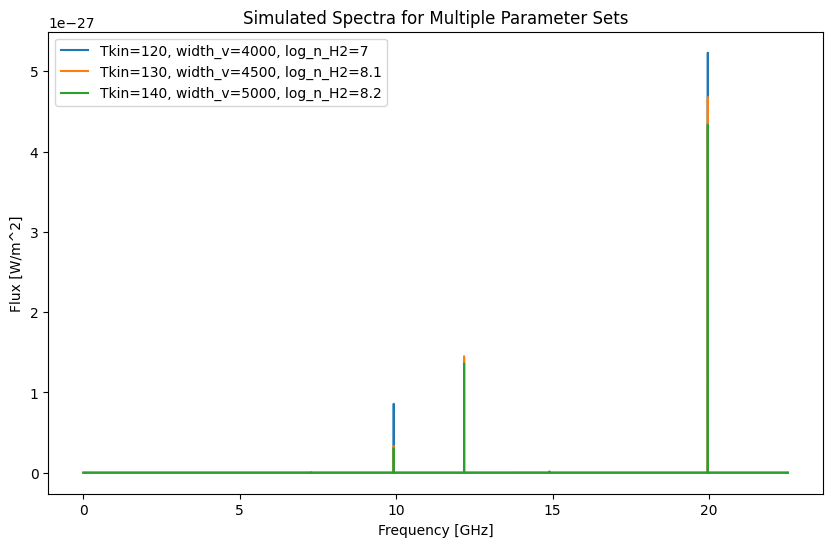

In [ ]:
# Define multiple sets of parameters
parameter_sets = [(120, 4000, 7), (130, 4500, 8.1), (140, 5000, 8.2)]

# Plot all spectra
plt.figure(figsize=(10, 6))
for Tkin_candidate, width_v_candidate, log_n_H2_candidate in parameter_sets:
    spec = simulate_spectrum_from_params(Tkin_candidate, width_v_candidate, log_n_H2_candidate)
    plt.plot(x / constants.giga, spec, label=f"Tkin={Tkin_candidate}, width_v={width_v_candidate}, log_n_H2={log_n_H2_candidate}")

plt.xlabel("Frequency [GHz]")
plt.ylabel(r"Flux [W/m^2]")
plt.legend()
plt.title("Simulated Spectra for Multiple Parameter Sets")
plt.show()

# Define log_likelihood, log_prior and log_probability


In [13]:
# Define the log-likelihood function assuming Gaussian errors
def log_likelihood(theta, x, y, yerr):
    amplitude, center, width = theta
    model = gaussian(x, amplitude, center, width)
    log_likelihood_value = -0.5 * np.sum(((y - model) / yerr) ** 2)
    return log_likelihood_value


def log_likelihood_radex(theta, x, y, yerr):
    Tkin_candidate, width_v_candidate, log_n_H2_candidate = theta
    print(f"Evaluating log_likelihood with theta: {theta}")
    model = simulate_spectrum_from_params(Tkin_candidate, width_v_candidate, log_n_H2_candidate)
    log_likelihood_value = -0.5 * np.sum(((y - model) / yerr) ** 2)
    print(f"log_likelihood: {log_likelihood_value}")
    return log_likelihood_value


# Define the log-prior (set ranges to include the true values)
def log_prior(theta):
    Tkin_candidate, width_v_candidate, log_n_H2_candidate = theta
    if 100 < Tkin_candidate < 150 and 1950 < width_v_candidate < 2050 and 7.8 < log_n_H2_candidate < 8.2:
        return 0.0
    return -np.inf


# def log_prior(theta):
#     Tkin_candidate, width_v_candidate, log_n_H2_candidate = theta
#     if 50 < Tkin_candidate < 300 and 1000 < width_v_candidate < 3000 and 5 < log_n_H2_candidate < 10:
#         return 0.0
#     return -np.inf


# Combine to form the full log-probability function
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_radex(theta, x, y, yerr)

Running MCMC... (this may take a while)


MCMC Sampling:   0%|          | 0/5 [00:00<?, ?step/s]

Evaluating log_likelihood with theta: [ 141.03059459 2038.44645233    8.10575437]
79-78: tau_nu0 = -0.187
46-45: tau_nu0 = -0.254
132-131: tau_nu0 = -0.000213
28-27: tau_nu0 = -3.64e-05
78-77: tau_nu0 = -0.000252
20-19: tau_nu0 = -5.19e-06
13-12: tau_nu0 = -0.646
18-17: tau_nu0 = -0.842
10-8: tau_nu0 = -0.379
23-22: tau_nu0 = -0.993
30-27: tau_nu0 = -1.1
37-36: tau_nu0 = -1.17
44-43: tau_nu0 = -1.19
54-53: tau_nu0 = -1.17
65-64: tau_nu0 = -1.13
49-48: tau_nu0 = -5.74e-12
79-77: tau_nu0 = -1.04
92-91: tau_nu0 = -0.947
105-104: tau_nu0 = -0.816
121-120: tau_nu0 = -0.676
14-12: tau_nu0 = -0.046
136-135: tau_nu0 = -0.196
68-66: tau_nu0 = -8.44e-06
9-7: tau_nu0 = -0.524
38-37: tau_nu0 = -1.06e-05
86-85: tau_nu0 = -0.0838
10-7: tau_nu0 = -1.55e-06
92-89: tau_nu0 = -0.17
59-56: tau_nu0 = -0.231
117-116: tau_nu0 = -5.54e-05
38-36: tau_nu0 = -5.02e-05
13-11: tau_nu0 = -1.6e-08
66-64: tau_nu0 = -0.000206
15-14: tau_nu0 = -1.99e-06
58-55: tau_nu0 = -2.32e-11
19-17: tau_nu0 = -0.0418
80-78: tau_nu

C:\Users\alios\OneDrive - University College London\Desktop\UCL\Year3\PHAS0056_Machine_Learning\emcee\src\emcee\moves\red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


79-78: tau_nu0 = -0.189
46-45: tau_nu0 = -0.256
132-131: tau_nu0 = -0.000202
28-27: tau_nu0 = -3.67e-05
78-77: tau_nu0 = -0.000249
20-19: tau_nu0 = -5.19e-06
13-12: tau_nu0 = -0.651
18-17: tau_nu0 = -0.848
10-8: tau_nu0 = -0.382
23-22: tau_nu0 = -0.999
30-27: tau_nu0 = -1.11
37-36: tau_nu0 = -1.17
44-43: tau_nu0 = -1.2
54-53: tau_nu0 = -1.18
65-64: tau_nu0 = -1.13
49-48: tau_nu0 = -5.75e-12
79-77: tau_nu0 = -1.05
92-91: tau_nu0 = -0.947
105-104: tau_nu0 = -0.815
121-120: tau_nu0 = -0.674
14-12: tau_nu0 = -0.0462
136-135: tau_nu0 = -0.194
68-66: tau_nu0 = -8.84e-06
9-7: tau_nu0 = -0.528
38-37: tau_nu0 = -1.05e-05
86-85: tau_nu0 = -0.0832
10-7: tau_nu0 = -1.56e-06
92-89: tau_nu0 = -0.171
59-56: tau_nu0 = -0.232
117-116: tau_nu0 = -4.46e-05
38-36: tau_nu0 = -5.04e-05
13-11: tau_nu0 = -1.61e-08
66-64: tau_nu0 = -0.000203
15-14: tau_nu0 = -1.99e-06
58-55: tau_nu0 = -2.32e-11
19-17: tau_nu0 = -0.0418
80-78: tau_nu0 = -7.25e-06
16-14: tau_nu0 = -0.568
75-73: tau_nu0 = -0.0727
105-103: tau_nu0

MCMC Sampling:  20%|██        | 1/5 [01:22<05:28, 82.17s/step]

79-78: tau_nu0 = -0.189
46-45: tau_nu0 = -0.257
132-131: tau_nu0 = -0.000196
28-27: tau_nu0 = -3.68e-05
78-77: tau_nu0 = -0.000247
20-19: tau_nu0 = -5.2e-06
13-12: tau_nu0 = -0.653
18-17: tau_nu0 = -0.851
10-8: tau_nu0 = -0.383
23-22: tau_nu0 = -1
30-27: tau_nu0 = -1.11
37-36: tau_nu0 = -1.18
44-43: tau_nu0 = -1.2
54-53: tau_nu0 = -1.18
65-64: tau_nu0 = -1.13
49-48: tau_nu0 = -5.75e-12
79-77: tau_nu0 = -1.05
92-91: tau_nu0 = -0.947
105-104: tau_nu0 = -0.815
121-120: tau_nu0 = -0.674
14-12: tau_nu0 = -0.0463
136-135: tau_nu0 = -0.193
68-66: tau_nu0 = -9.08e-06
9-7: tau_nu0 = -0.53
38-37: tau_nu0 = -1.06e-05
86-85: tau_nu0 = -0.0828
10-7: tau_nu0 = -1.57e-06
92-89: tau_nu0 = -0.172
59-56: tau_nu0 = -0.233
117-116: tau_nu0 = -3.88e-05
38-36: tau_nu0 = -5.05e-05
13-11: tau_nu0 = -1.62e-08
66-64: tau_nu0 = -0.000202
15-14: tau_nu0 = -1.99e-06
58-55: tau_nu0 = -2.32e-11
19-17: tau_nu0 = -0.0418
80-78: tau_nu0 = -7.72e-06
16-14: tau_nu0 = -0.57
75-73: tau_nu0 = -0.0723
105-103: tau_nu0 = -0.1

MCMC Sampling:  40%|████      | 2/5 [02:00<02:49, 56.59s/step]

79-78: tau_nu0 = -0.191
46-45: tau_nu0 = -0.257
132-131: tau_nu0 = -0.000208
28-27: tau_nu0 = -3.68e-05
78-77: tau_nu0 = -0.000252
20-19: tau_nu0 = -5.22e-06
13-12: tau_nu0 = -0.651
18-17: tau_nu0 = -0.849
10-8: tau_nu0 = -0.382
23-22: tau_nu0 = -1
30-27: tau_nu0 = -1.11
37-36: tau_nu0 = -1.18
44-43: tau_nu0 = -1.2
54-53: tau_nu0 = -1.19
65-64: tau_nu0 = -1.14
49-48: tau_nu0 = -5.75e-12
79-77: tau_nu0 = -1.06
92-91: tau_nu0 = -0.96
105-104: tau_nu0 = -0.828
121-120: tau_nu0 = -0.686
14-12: tau_nu0 = -0.0464
136-135: tau_nu0 = -0.198
68-66: tau_nu0 = -9.04e-06
9-7: tau_nu0 = -0.528
38-37: tau_nu0 = -1.12e-05
86-85: tau_nu0 = -0.0836
10-7: tau_nu0 = -1.56e-06
92-89: tau_nu0 = -0.173
59-56: tau_nu0 = -0.234
117-116: tau_nu0 = -4.93e-05
38-36: tau_nu0 = -5.07e-05
13-11: tau_nu0 = -1.62e-08
66-64: tau_nu0 = -0.000207
15-14: tau_nu0 = -2.01e-06
58-55: tau_nu0 = -2.32e-11
19-17: tau_nu0 = -0.0425
80-78: tau_nu0 = -7.94e-06
16-14: tau_nu0 = -0.57
75-73: tau_nu0 = -0.073
105-103: tau_nu0 = -0.1

MCMC Sampling:  60%|██████    | 3/5 [02:39<01:36, 48.42s/step]

79-78: tau_nu0 = -0.194
46-45: tau_nu0 = -0.261
132-131: tau_nu0 = -0.000195
28-27: tau_nu0 = -3.72e-05
78-77: tau_nu0 = -0.000249
20-19: tau_nu0 = -5.24e-06
13-12: tau_nu0 = -0.659
18-17: tau_nu0 = -0.859
10-8: tau_nu0 = -0.386
23-22: tau_nu0 = -1.01
30-27: tau_nu0 = -1.12
37-36: tau_nu0 = -1.19
44-43: tau_nu0 = -1.21
54-53: tau_nu0 = -1.2
65-64: tau_nu0 = -1.15
49-48: tau_nu0 = -5.76e-12
79-77: tau_nu0 = -1.06
92-91: tau_nu0 = -0.965
105-104: tau_nu0 = -0.832
121-120: tau_nu0 = -0.688
14-12: tau_nu0 = -0.0468
136-135: tau_nu0 = -0.198
68-66: tau_nu0 = -9.72e-06
9-7: tau_nu0 = -0.535
38-37: tau_nu0 = -1.14e-05
86-85: tau_nu0 = -0.0828
10-7: tau_nu0 = -1.58e-06
92-89: tau_nu0 = -0.176
59-56: tau_nu0 = -0.237
117-116: tau_nu0 = -3.55e-05
38-36: tau_nu0 = -5.12e-05
13-11: tau_nu0 = -1.64e-08
66-64: tau_nu0 = -0.000204
15-14: tau_nu0 = -2.02e-06
58-55: tau_nu0 = -2.33e-11
19-17: tau_nu0 = -0.0428
80-78: tau_nu0 = -9.3e-06
16-14: tau_nu0 = -0.577
75-73: tau_nu0 = -0.0723
105-103: tau_nu0 =

MCMC Sampling:  80%|████████  | 4/5 [03:27<00:48, 48.06s/step]

79-78: tau_nu0 = -0.19
46-45: tau_nu0 = -0.257
132-131: tau_nu0 = -0.000206
28-27: tau_nu0 = -3.68e-05
78-77: tau_nu0 = -0.000251
20-19: tau_nu0 = -5.21e-06
13-12: tau_nu0 = -0.651
18-17: tau_nu0 = -0.849
10-8: tau_nu0 = -0.382
23-22: tau_nu0 = -1
30-27: tau_nu0 = -1.11
37-36: tau_nu0 = -1.18
44-43: tau_nu0 = -1.2
54-53: tau_nu0 = -1.18
65-64: tau_nu0 = -1.14
49-48: tau_nu0 = -5.75e-12
79-77: tau_nu0 = -1.05
92-91: tau_nu0 = -0.956
105-104: tau_nu0 = -0.824
121-120: tau_nu0 = -0.682
14-12: tau_nu0 = -0.0463
136-135: tau_nu0 = -0.197
68-66: tau_nu0 = -9e-06
9-7: tau_nu0 = -0.528
38-37: tau_nu0 = -1.1e-05
86-85: tau_nu0 = -0.0834
10-7: tau_nu0 = -1.56e-06
92-89: tau_nu0 = -0.173
59-56: tau_nu0 = -0.234
117-116: tau_nu0 = -4.73e-05
38-36: tau_nu0 = -5.06e-05
13-11: tau_nu0 = -1.62e-08
66-64: tau_nu0 = -0.000205
15-14: tau_nu0 = -2e-06
58-55: tau_nu0 = -2.32e-11
19-17: tau_nu0 = -0.0423
80-78: tau_nu0 = -7.78e-06
16-14: tau_nu0 = -0.569
75-73: tau_nu0 = -0.0729
105-103: tau_nu0 = -0.148
15

MCMC Sampling: 100%|██████████| 5/5 [04:10<00:00, 50.12s/step]


79-78: tau_nu0 = -0.19
46-45: tau_nu0 = -0.257
132-131: tau_nu0 = -0.000197
28-27: tau_nu0 = -3.67e-05
78-77: tau_nu0 = -0.000248
20-19: tau_nu0 = -5.2e-06
13-12: tau_nu0 = -0.652
18-17: tau_nu0 = -0.85
10-8: tau_nu0 = -0.383
23-22: tau_nu0 = -1
30-27: tau_nu0 = -1.11
37-36: tau_nu0 = -1.18
44-43: tau_nu0 = -1.2
54-53: tau_nu0 = -1.18
65-64: tau_nu0 = -1.13
49-48: tau_nu0 = -5.74e-12
79-77: tau_nu0 = -1.05
92-91: tau_nu0 = -0.949
105-104: tau_nu0 = -0.817
121-120: tau_nu0 = -0.675
14-12: tau_nu0 = -0.0462
136-135: tau_nu0 = -0.194
68-66: tau_nu0 = -9.1e-06
9-7: tau_nu0 = -0.529
38-37: tau_nu0 = -1.07e-05
86-85: tau_nu0 = -0.0829
10-7: tau_nu0 = -1.57e-06
92-89: tau_nu0 = -0.172
59-56: tau_nu0 = -0.233
117-116: tau_nu0 = -4.03e-05
38-36: tau_nu0 = -5.05e-05
13-11: tau_nu0 = -1.62e-08
66-64: tau_nu0 = -0.000202
15-14: tau_nu0 = -1.99e-06
58-55: tau_nu0 = -2.32e-11
19-17: tau_nu0 = -0.0419
80-78: tau_nu0 = -7.85e-06
16-14: tau_nu0 = -0.57
75-73: tau_nu0 = -0.0724
105-103: tau_nu0 = -0.147

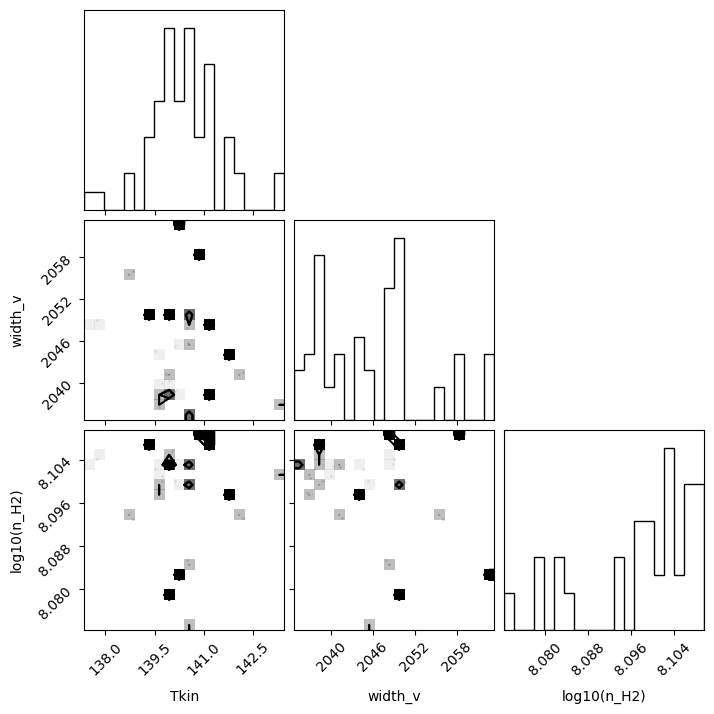

79-78: tau_nu0 = -0.189
46-45: tau_nu0 = -0.256
132-131: tau_nu0 = -0.0002
28-27: tau_nu0 = -3.67e-05
78-77: tau_nu0 = -0.000248
20-19: tau_nu0 = -5.19e-06
13-12: tau_nu0 = -0.651
18-17: tau_nu0 = -0.848
10-8: tau_nu0 = -0.382
23-22: tau_nu0 = -0.999
30-27: tau_nu0 = -1.11
37-36: tau_nu0 = -1.17
44-43: tau_nu0 = -1.2
54-53: tau_nu0 = -1.18
65-64: tau_nu0 = -1.13
49-48: tau_nu0 = -5.74e-12
79-77: tau_nu0 = -1.05
92-91: tau_nu0 = -0.949
105-104: tau_nu0 = -0.817
121-120: tau_nu0 = -0.676
14-12: tau_nu0 = -0.0462
136-135: tau_nu0 = -0.194
68-66: tau_nu0 = -8.99e-06
9-7: tau_nu0 = -0.528
38-37: tau_nu0 = -1.07e-05
86-85: tau_nu0 = -0.0831
10-7: tau_nu0 = -1.56e-06
92-89: tau_nu0 = -0.172
59-56: tau_nu0 = -0.233
117-116: tau_nu0 = -4.34e-05
38-36: tau_nu0 = -5.04e-05
13-11: tau_nu0 = -1.61e-08
66-64: tau_nu0 = -0.000203
15-14: tau_nu0 = -1.99e-06
58-55: tau_nu0 = -2.32e-11
19-17: tau_nu0 = -0.0419
80-78: tau_nu0 = -7.64e-06
16-14: tau_nu0 = -0.568
75-73: tau_nu0 = -0.0726
105-103: tau_nu0 =

c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:110: UserWarning: some lines are overlapping, but treatement of overlapping lines not activated
  warnings.warn('some lines are overlapping, but treatement of'
c:\Users\alios\AppData\Local\Programs\Python\Python312\Lib\site-packages\pythonradex\radiative_transfer.py:333: UserWarning: negative optical depth!
  warnings.warn('negative optical depth!')


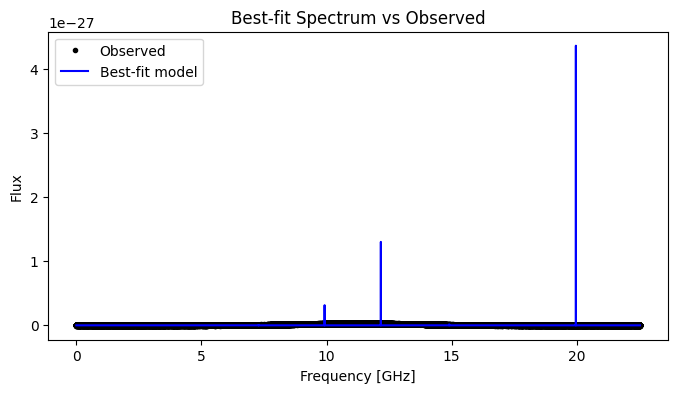

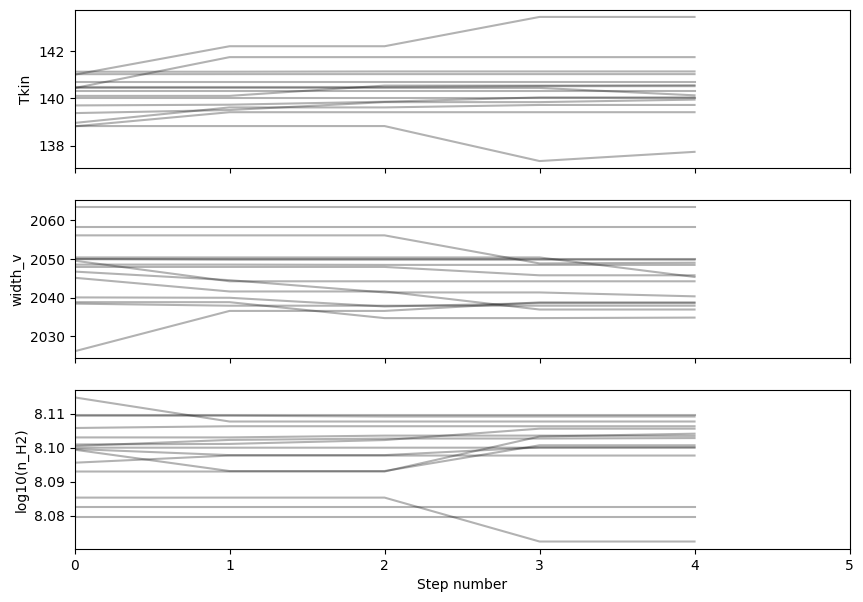

In [14]:
# reset sampler to zero
samples = []
pos = []

# Initial guess for the parameters [Tkin, width_v, log10(n_H2)]
initial = np.array([140, 2050, 8.1])
ndim = len(initial)
nwalkers = 15

# Define noise levels for each parameter
noise_levels = np.array([1, 10, 0.01])  # Adjust these values as needed

# Initialize walkers in a small Gaussian ball around the initial guess
pos = initial + noise_levels * np.random.randn(nwalkers, ndim)

# Initialize walkers in a small Gaussian ball around the initial guess
# pos = initial + 1 * np.random.randn(nwalkers, ndim)

print("Running MCMC... (this may take a while)")
nsteps = 5
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, observed_spectrum, noise_std))
with tqdm(total=nsteps, desc="MCMC Sampling", unit="step") as pbar:
    for result in sampler.sample(pos, iterations=nsteps, progress=False):  # Disable emcee's built-in progress bar
        pbar.update(1)  # Update tqdm progress bar

# Discard burn-in and flatten the chain
burnin = int(0.3 * nsteps)
samples = sampler.get_chain(discard=burnin, flat=True)
print("Mean parameter estimates [Tkin, width_v, log10(n_H2)]:")
print(np.mean(samples, axis=0))


# Create a corner plot for the posterior samples
fig_corner = corner.corner(samples, labels=["Tkin", "width_v", "log10(n_H2)"], truths=[Tkin, width_v, 8.0])
plt.show()

# Plot the best-fit model vs the observed spectrum
Tkin_best, width_v_best, log_n_H2_best = np.median(samples, axis=0)
model_best = simulate_spectrum_from_params(Tkin_best, width_v_best, log_n_H2_best)

# print the best fit parameters
print(f"Best fit parameters: Tkin = {Tkin_best}, width_v = {width_v_best}, log10(n_H2) = {log_n_H2_best}")


plt.figure(figsize=(8, 4))
plt.plot(x / constants.giga, observed_spectrum, "k.", label="Observed")
plt.plot(x / constants.giga, model_best, "b-", label="Best-fit model")
plt.xlabel("Frequency [GHz]")
plt.ylabel("Flux")
plt.legend()
plt.title("Best-fit Spectrum vs Observed")
plt.show()

# Plot trace plots for each parameter
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["Tkin", "width_v", "log10(n_H2)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel("Step number")
plt.show()


In [15]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 143.4569558 , 2036.92054993,    8.10067699])